Define functional categories and filter calls for those in Control and SCZ individuals

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import attila_utils
import funcvar
import functools
import ensembl_rest
import os.path
from bsmcalls import SNPnexus
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

/home/attila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


## Preparations

In [2]:
annot = SNPnexus.read_annot()

In [3]:
colnamel = ['near_gens_Type', 'near_gens_Annotation', 'ensembl_Predicted Function', 'sift_Prediction']
nonestrl = ['None', 'None', 'other', 'other']
data = SNPnexus.expand_multiple_setvalued(annot, colnamel=colnamel, nonestrl=nonestrl)

Let's shorten the name of `data` to `D`!

In [4]:
D = data

## Further preparations
### Genes overlapping a variant

The set of genes overlapping a variant is in the `near_gens_Overlapped Gene` feature/column.  The data type of this column is `string`, which is not convenient for set semantics. Therefore we create a Python `set` for each gene set and insert the corresponding column right after `near_gens_Overlapped Gene`.

In [5]:
def insert_geneset(df, col='near_gens_Overlapped Gene', sepstr=':', nonestr='None', listval=False):
    loc = list(df.columns).index(col) + 1
    value = SNPnexus.str2set_setvalued(df, col, nonestr, sepstr, listval=listval)
    column = col + ' set'
    if not column in df.columns:
        df.insert(loc=loc, column=column, value=value)
    return(None)

insert_geneset(D, col='near_gens_Overlapped Gene', sepstr=':', nonestr='None', listval=False)

### GWAS genes

Here we take supplementary table 4 from the [CLOZUK paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5918692/) (clozapine UK), whose `Gene(s) tagged` column we turn into the `gwasgenes` set.

In [6]:
clozukpath = '/home/attila/projects/bsm/resources/CLOZUK/supp-table-4.csv'
gwasgenes = funcvar.get_geneset(df=pd.read_csv(clozukpath, skiprows=7), col='Gene(s) tagged')
gwasgenesl = list(gwasgenes)
gwasgenesl.sort()
print(len(gwasgenes), 'schizophrenia GWAS genes')
repr(gwasgenesl)

478 schizophrenia GWAS genes


"['ABCB9', 'ACD', 'ACTR5', 'ADAMTS7P1', 'ADAMTSL3', 'ADM5', 'AIG1', 'AKAP6', 'AKT3', 'AL050132', 'ALDOA', 'ALMS1', 'ALMS1-IT1', 'ALMS1P', 'ALPK3', 'AMBRA1', 'ANKRD44', 'ANKRD44-IT1', 'ANKRD63', 'ANP32E', 'AP3B2', 'ARHGAP1', 'ARL14EP', 'ARL6IP4', 'AS3MT', 'ASCL1', 'ASH2L', 'ASPG', 'ASPHD1', 'ATG13', 'ATP2A2', 'ATPAF2', 'ATXN7', 'B3GAT1', 'BAG4', 'BANK1', 'BC037927', 'BCL11B', 'BCL2L12', 'BNIP3L', 'BOLL', 'BRINP2', 'BTBD18', 'BTG1', 'C10orf32', 'C10orf32-ASMT', 'C11orf31', 'C12orf65', 'C14orf2', 'C16orf86', 'C16orf92', 'C2orf47', 'C2orf69', 'C2orf82', 'C3orf49', 'C4orf27', 'CA14', 'CA8', 'CACNA1C', 'CACNA1C-AS4', 'CACNA1C-IT3', 'CACNA1D', 'CACNA1I', 'CACNB2', 'CALB2', 'CCDC175', 'CDK2AP1', 'CENPM', 'CENPT', 'CHADL', 'CHRM3', 'CHRM4', 'CHRNA2', 'CHRNA3', 'CHRNA5', 'CHRNB4', 'CILP2', 'CKAP5', 'CLCN3', 'CLP1', 'CLU', 'CMTR2', 'CNNM2', 'CNOT1', 'CNTN4', 'COQ10B', 'CPEB1', 'CPNE8', 'CPT1C', 'CREB3L1', 'CSMD1', 'CTNND1', 'CTRL', 'CUL3', 'CYP17A1', 'CYP2D6', 'CYP2D7P', 'DDHD2', 'DDX28', 'DFNA5'

In [7]:
def insert_gwasgeneset(df, col='near_gens_Overlapped Gene set', newcolprefix='near_gens_Overlapped', dtype='set'):
    loc = list(df.columns).index(col) + 1
    if dtype == 'set':
        foo = lambda x: x
    elif dtype == 'num':
        foo = len
    elif dtype == 'bool':
        foo = lambda x: bool(len(x))
    value = [foo(y.intersection(gwasgenesl)) for y in df[col]]
    suffix = {'set': ' SCZ GWAS Genes', 'num': ' SCZ GWAS Genes num', 'bool': ' SCZ GWAS genes any'}
    column = newcolprefix + suffix[dtype]
    if not column in df.columns:
        df.insert(loc=loc, column=column, value=value)
    return(None)

for dtype in ['bool', 'num', 'set']:
    insert_gwasgeneset(df=D, dtype=dtype)

### DeepSEA score
[DeepSEA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768299/) predicts effects of noncoding variants with deep learning–based sequence model.

['named-figure/deepsea-hist.png', 'named-figure/deepsea-hist.pdf']

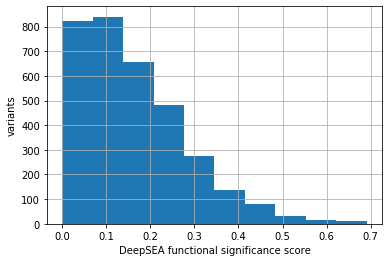

In [8]:
fig, ax = plt.subplots()
D['deepsea_Functional Significance Score'].hist(ax=ax)
ax.set_xlabel('DeepSEA functional significance score')
ax.set_ylabel('variants')
attila_utils.savefig(fig, 'deepsea-hist')

The histogram suggests a cutoff somewhere between 0.5 and 0.6 score.  I will define functionally significant variants using both a more lenient and a more stringent threshold.

In [9]:
def insert_deepsea(thrs):
    loc = list(D.columns).index('deepsea_Functional Significance Score') + 1
    value = D['deepsea_Functional Significance Score'] >= thrs
    column = 'deepsea_Functional Significance Score >= ' + str(thrs)
    if not column in D.columns:
        D.insert(loc=loc, column=column, value=value)
    count = D[column].sum()
    print(count, 'variants with', column)
    return(None)

insert_deepsea(0.6)
insert_deepsea(0.5)

15 variants with deepsea_Functional Significance Score >= 0.6
55 variants with deepsea_Functional Significance Score >= 0.5


### Ensembl gene description

In [10]:
outcsv = '/home/attila/projects/bsm/results/2020-11-13-functional-variants/expanded-annotated-calls.csv'
# a long run
if not os.path.exists(outcsv):
    description = SNPnexus.ensembl_description(data, colname='near_gens_Overlapped Gene set')
    D = SNPnexus.insert_col(description, D, 'near_gens_Overlapped Gene set', 'near_gens_Overlapped Gene set description', inplace=False)
    D.to_csv(outcsv)

### Import the expanded data set

In [11]:
D = SNPnexus.read_annot(outcsv)

## Filterings

In [12]:
filtl = ['coding nonsyn', 'stop-gain', 'intronic (splice_site)', 'regbuild_Epigenome_nervoussys_bin', 'tfbs_TFBS Name_bin', 'Deleterious', 'Deleterious - Low Confidence', 'deepsea_Functional Significance Score >= 0.6', 'gerp_Element RS Score_bin']
counts = funcvar.filtered_Dx_counts(D, filtl=filtl, gb='Dx')
counts

Dx,Control,SCZ,Total
coding nonsyn,15,44,59
stop-gain,0,4,4
intronic (splice_site),0,1,1
regbuild_Epigenome_nervoussys_bin,208,521,729
tfbs_TFBS Name_bin,22,79,101
Deleterious,6,14,20
Deleterious - Low Confidence,1,3,4
deepsea_Functional Significance Score >= 0.6,3,12,15
gerp_Element RS Score_bin,75,265,340


### Functional variants

First let's see Taejeong's definition of functional variants

> The terms that we chose as functional are missense, stop_gained, splice_region, regulatory, and TF_binding.

In [13]:
funcAby_cols = ['coding nonsyn', 'stop-gain', 'intronic (splice_site)', 'tfbs_TFBS Name_bin', 'regbuild_Epigenome_nervoussys_bin']

def get_funcAby(cols=funcAby_cols, df=D):
    l = [df[s] for s in cols]
    val = functools.reduce(lambda x, y: x | y, l)
    return(val)

funcAby = functools.reduce(lambda x, y: x | y, [D[s] for s in funcAby_cols])
funcAby_no_regulatory = functools.reduce(lambda x, y: x | y, [D[s] for s in funcAby_cols[:-1]])
print('Functional variants according to criteria by the Abyzov lab:')
print(sum(funcAby), 'total')
print(sum(funcAby_no_regulatory), 'excluding regulatory')

Functional variants according to criteria by the Abyzov lab:
840 total
143 excluding regulatory


In [14]:
sel_cols = ['Dx', 'near_gens_Overlapped Gene', 'near_gens_Overlapped SCZ GWAS Genes', 'encode_Feature Type Class']
sel_cols1 = ['Dx', 'near_gens_Overlapped Gene', 'near_gens_Overlapped Gene set description', 'near_gens_Overlapped SCZ GWAS Genes', 'encode_Feature Type Class']

### Coding variants predicted as deleterious

In [15]:
D.loc[D['Deleterious'], sel_cols]#.sort_values(by='Dx')

Dx  \
Individual ID Tissue  CHROM POS       Mutation            
CMC_MSSM_055  NeuN_pl 4     187194260 C/T       Control   
CMC_MSSM_097  NeuN_pl 3     49330027  A/G       SCZ       
                      11    126136475 G/A       SCZ       
CMC_MSSM_099  NeuN_pl 3     49083922  C/T       Control   
CMC_MSSM_100  NeuN_pl 6     42986648  C/A       Control   
                      7     128480112 G/A       Control   
CMC_MSSM_106  NeuN_pl 10    33474609  A/G       Control   
                      16    1537659   C/T       Control   
CMC_MSSM_142  NeuN_pl 13    21742430  C/T       SCZ       
CMC_MSSM_162  NeuN_pl 12    104682742 A/C       SCZ       
CMC_MSSM_168  NeuN_pl 12    121176354 C/T       SCZ       
CMC_MSSM_180  NeuN_pl 3     169540341 C/T       SCZ       
CMC_MSSM_224  NeuN_pl 16    682738    G/A       SCZ       
                      19    15271813  G/A       SCZ       
CMC_MSSM_362  NeuN_pl 10    81929099  C/T       SCZ       
CMC_MSSM_363  NeuN_pl 1     22176560  C/T       SCZ       
CMC_MSSM_379  NeuN_pl 19    19308414  G/A       SCZ       
CMC_MSSM_415  NeuN_pl 16    90109610  A/C       SCZ       
CMC_PITT_020  NeuN_pl 6     155732472 C/T       SCZ       
CMC_PITT_052  NeuN_pl 1     167358841 G/A       SCZ       

                                               near_gens_Overlapped Gene  \
Individual ID Tissue  CHROM POS       Mutation                             
CMC_MSSM_055  NeuN_pl 4     187194260 C/T       F11                        
CMC_MSSM_097  NeuN_pl 3     49330027  A/G       USP4                       
                      11    126136475 G/A       SRPR                       
CMC_MSSM_099  NeuN_pl 3     49083922  C/T       QRICH1                     
CMC_MSSM_100  NeuN_pl 6     42986648  C/A       KLHDC3                     
                      7     128480112 G/A       FLNC                       
CMC_MSSM_106  NeuN_pl 10    33474609  A/G       NRP1                       
                      16    1537659   C/T       PTX4                       
CMC_MSSM_142  NeuN_pl 13    21742430  C/T       SKA3                       
CMC_MSSM_162  NeuN_pl 12    104682742 A/C       TXNRD1                     
CMC_MSSM_168  NeuN_pl 12    121176354 C/T       ACADS                      
CMC_MSSM_180  NeuN_pl 3     169540341 C/T       LRRIQ4                     
CMC_MSSM_224  NeuN_pl 16    682738    G/A       WFIKKN1                    
                      19    15271813  G/A       NOTCH3                     
CMC_MSSM_362  NeuN_pl 10    81929099  C/T       ANXA11                     
CMC_MSSM_363  NeuN_pl 1     22176560  C/T       HSPG2                      
CMC_MSSM_379  NeuN_pl 19    19308414  G/A       RFXANK                     
CMC_MSSM_415  NeuN_pl 16    90109610  A/C       GAS8:URAHP                 
CMC_PITT_020  NeuN_pl 6     155732472 C/T       NOX3                       
CMC_PITT_052  NeuN_pl 1     167358841 G/A       POU2F1                     

                                               near_gens_Overlapped SCZ GWAS Genes  \
Individual ID Tissue  CHROM POS       Mutation                                       
CMC_MSSM_055  NeuN_pl 4     187194260 C/T       set()                                
CMC_MSSM_097  NeuN_pl 3     49330027  A/G       set()                                
                      11    126136475 G/A       set()                                
CMC_MSSM_099  NeuN_pl 3     49083922  C/T       set()                                
CMC_MSSM_100  NeuN_pl 6     42986648  C/A       set()                                
                      7     128480112 G/A       set()                                
CMC_MSSM_106  NeuN_pl 10    33474609  A/G       set()                                
                      16    1537659   C/T       set()                                
CMC_MSSM_142  NeuN_pl 13    21742430  C/T       set()                                
CMC_MSSM_162  NeuN_pl 12    104682742 A/C       set()                                
CMC_MSSM_168  NeuN_pl 12    121176354 C/T       s

### Noncoding variants predicted as functional

In [16]:
D.loc[D['deepsea_Functional Significance Score >= 0.6'], sel_cols]

Dx  \
Individual ID Tissue  CHROM POS       Mutation            
CMC_MSSM_100  NeuN_pl X     79208397  T/A       Control   
CMC_MSSM_130  NeuN_pl 6     115507207 T/C       Control   
CMC_MSSM_168  NeuN_pl 20    47794232  T/A       SCZ       
CMC_MSSM_178  NeuN_pl 2     139696021 T/G       Control   
CMC_MSSM_180  NeuN_pl 11    88899522  G/A       SCZ       
CMC_MSSM_222  NeuN_pl 11    9176379   T/A       SCZ       
CMC_MSSM_224  NeuN_pl 3     4984807   T/C       SCZ       
CMC_MSSM_305  NeuN_pl 9     107282115 T/A       SCZ       
                      13    87792531  T/C       SCZ       
CMC_MSSM_343  NeuN_pl 13    84127480  G/T       SCZ       
CMC_MSSM_352  NeuN_pl 3     148084503 A/T       SCZ       
CMC_MSSM_366  NeuN_pl 1     110126012 T/A       SCZ       
CMC_PITT_020  NeuN_pl 4     146490796 G/C       SCZ       
CMC_PITT_071  NeuN_pl 13    55121881  A/T       SCZ       
CMC_PITT_072  NeuN_pl 5     82059915  C/A       SCZ       

                                               near_gens_Overlapped Gene  \
Individual ID Tissue  CHROM POS       Mutation                             
CMC_MSSM_100  NeuN_pl X     79208397  T/A       None                       
CMC_MSSM_130  NeuN_pl 6     115507207 T/C       None                       
CMC_MSSM_168  NeuN_pl 20    47794232  T/A       STAU1                      
CMC_MSSM_178  NeuN_pl 2     139696021 T/G       None                       
CMC_MSSM_180  NeuN_pl 11    88899522  G/A       None                       
CMC_MSSM_222  NeuN_pl 11    9176379   T/A       DENND5A                    
CMC_MSSM_224  NeuN_pl 3     4984807   T/C       BHLHE40-AS1                
CMC_MSSM_305  NeuN_pl 9     107282115 T/A       None                       
                      13    87792531  T/C       None                       
CMC_MSSM_343  NeuN_pl 13    84127480  G/T       None                       
CMC_MSSM_352  NeuN_pl 3     148084503 A/T       RP11-501O2.5               
CMC_MSSM_366  NeuN_pl 1     110126012 T/A       GNAI3                      
CMC_PITT_020  NeuN_pl 4     146490796 G/C       None                       
CMC_PITT_071  NeuN_pl 13    55121881  A/T       None                       
CMC_PITT_072  NeuN_pl 5     82059915  C/A       None                       

                                               near_gens_Overlapped SCZ GWAS Genes  \
Individual ID Tissue  CHROM POS       Mutation                                       
CMC_MSSM_100  NeuN_pl X     79208397  T/A       set()                                
CMC_MSSM_130  NeuN_pl 6     115507207 T/C       set()                                
CMC_MSSM_168  NeuN_pl 20    47794232  T/A       set()                                
CMC_MSSM_178  NeuN_pl 2     139696021 T/G       set()                                
CMC_MSSM_180  NeuN_pl 11    88899522  G/A       set()                                
CMC_MSSM_222  NeuN_pl 11    9176379   T/A       set()                                
CMC_MSSM_224  NeuN_pl 3     4984807   T/C       set()                                
CMC_MSSM_305  NeuN_pl 9     107282115 T/A       set()                                
                      13    87792531  T/C       set()                                
CMC_MSSM_343  NeuN_pl 13    84127480  G/T       set()                                
CMC_MSSM_352  NeuN_pl 3     148084503 A/T       set()                                
CMC_MSSM_366  NeuN_pl 1     110126012 T/A       set()                                
CMC_PITT_020  NeuN_pl 4     146490796 G/C       set()                                
CMC_PITT_071  NeuN_pl 13    55121881  A/T       set()                                
CMC_PITT_072  NeuN_pl 5     82059915  C/A       set()                                

                                               encode_Feature Type Class  
Individual ID Tissue  CHROM POS       Mutation                            
CMC_MSSM_100  NeuN_pl X     79208397  T/A       Histone                   
CMC_MSSM_130  NeuN_pl 6     115507207 T/C       Histone             

### SCZ GWAS genes overlapping functional variants 

In [17]:
counts_SCZ_GWAS = funcvar.filtered_Dx_counts(D, filtl=filtl, gb='Dx', anygwas=D['near_gens_Overlapped SCZ GWAS genes any'])
counts_SCZ_GWAS

Dx,Control,SCZ,Total
coding nonsyn,0,0,0
stop-gain,0,0,0
intronic (splice_site),0,0,0
regbuild_Epigenome_nervoussys_bin,6,13,19
tfbs_TFBS Name_bin,0,2,2
Deleterious,0,0,0
Deleterious - Low Confidence,0,0,0
deepsea_Functional Significance Score >= 0.6,0,0,0
gerp_Element RS Score_bin,1,9,10


#### Functional variants with overlapping SCZ GWAS gene(s)

In [18]:
D.loc[funcAby & D['near_gens_Overlapped SCZ GWAS genes any'], sel_cols]

Dx  \
Individual ID Tissue  CHROM POS       Mutation            
CMC_MSSM_097  NeuN_pl 8     143313835 A/C       SCZ       
CMC_MSSM_106  NeuN_pl 6     143541413 A/G       Control   
CMC_MSSM_109  NeuN_pl 3     60745841  C/T       Control   
                      6     128820938 T/C       Control   
CMC_MSSM_213  NeuN_pl 15    78913052  T/G       SCZ       
                      16    7455256   C/T       SCZ       
                      17    78573310  T/G       SCZ       
                            78699501  A/C       SCZ       
CMC_MSSM_224  NeuN_pl 2     233752670 C/T       SCZ       
                      17    78669726  G/A       SCZ       
CMC_MSSM_273  NeuN_pl 8     10184212  A/G       SCZ       
CMC_MSSM_305  NeuN_pl 14    33173083  G/A       SCZ       
CMC_MSSM_340  NeuN_pl 3     53703284  C/G       SCZ       
CMC_MSSM_343  NeuN_pl 8     143385292 T/G       SCZ       
CMC_MSSM_352  NeuN_pl 1     97845569  T/A       SCZ       
CMC_MSSM_369  NeuN_pl 12    23913864  G/A       Control   
                      19    19367011  C/T       Control   
CMC_PITT_020  NeuN_pl 6     128611543 C/A       SCZ       
CMC_PITT_050  NeuN_pl 16    68271265  G/A       Control   
CMC_PITT_118  NeuN_pl 3     17343154  C/T       SCZ       
                      X     5889841   G/A       SCZ       

                                               near_gens_Overlapped Gene  \
Individual ID Tissue  CHROM POS       Mutation                             
CMC_MSSM_097  NeuN_pl 8     143313835 A/C       TSNARE1                    
CMC_MSSM_106  NeuN_pl 6     143541413 A/G       AIG1                       
CMC_MSSM_109  NeuN_pl 3     60745841  C/T       FHIT                       
                      6     128820938 T/C       PTPRK                      
CMC_MSSM_213  NeuN_pl 15    78913052  T/G       CHRNA3                     
                      16    7455256   C/T       RBFOX1                     
                      17    78573310  T/G       RPTOR                      
                            78699501  A/C       RPTOR                      
CMC_MSSM_224  NeuN_pl 2     233752670 C/T       NGEF                       
                      17    78669726  G/A       RPTOR                      
CMC_MSSM_273  NeuN_pl 8     10184212  A/G       MSRA                       
CMC_MSSM_305  NeuN_pl 14    33173083  G/A       AKAP6                      
CMC_MSSM_340  NeuN_pl 3     53703284  C/G       CACNA1D                    
CMC_MSSM_343  NeuN_pl 8     143385292 T/G       TSNARE1                    
CMC_MSSM_352  NeuN_pl 1     97845569  T/A       DPYD                       
CMC_MSSM_369  NeuN_pl 12    23913864  G/A       SOX5                       
                      19    19367011  C/T       HAPLN4:AC138430.4          
CMC_PITT_020  NeuN_pl 6     128611543 C/A       PTPRK                      
CMC_PITT_050  NeuN_pl 16    68271265  G/A       ESRP2:RP11-96D1.6          
CMC_PITT_118  NeuN_pl 3     17343154  C/T       TBC1D5                     
                      X     5889841   G/A       NLGN4X                     

                                               near_gens_Overlapped SCZ GWAS Genes  \
Individual ID Tissue  CHROM POS       Mutation                                       
CMC_MSSM_097  NeuN_pl 8     143313835 A/C       {'TSNARE1'}                          
CMC_MSSM_106  NeuN_pl 6     143541413 A/G       {'AIG1'}                             
CMC_MSSM_109  NeuN_pl 3     60745841  C/T       {'FHIT'}                             
                      6     128820938 T/C       {'PTPRK'}                            
CMC_MSSM_213  NeuN_pl 15    78913052  T/G       {'CHRNA3'}                           
                      16    7455256   C/T       {'RBFOX1'}                           
                      17    78573310  T/G       {'RPTOR'}                            
                            78699501  A/C       {'RPTOR'}                            
CMC_MSSM_224  NeuN_pl 2     233752670 C/T       {'NGEF'}                             


TSNARE1 is [t-SNARE domain-containing protein 1](https://www.uniprot.org/uniprot/Q96NA8)

AIG1 is [Androgen-induced gene 1 protein](https://www.uniprot.org/uniprot/Q9NVV5), which
> Hydrolyzes bioactive fatty-acid esters of hydroxy-fatty acids

FHIT is [Bis(5'-adenosyl)-triphosphatase](https://www.uniprot.org/uniprot/P49789), which
> Modulates transcriptional activation by CTNNB1 and thereby contributes to regulate the expression of genes essential for cell proliferation and survival, such as CCND1 and BIRC5. Plays a role in the induction of apoptosis via SRC and AKT1 signaling pathways.

PTPRK is [Receptor-type tyrosine-protein phosphatase kappa](https://www.uniprot.org/uniprot/Q15262), which is involved in
> Regulation of processes involving cell contact and adhesion such as growth control, tumor invasion, and metastasis. Negative regulator of EGFR signaling pathway.

CHRNA3 is [Neuronal acetylcholine receptor subunit alpha-3](https://www.uniprot.org/uniprot/P32297)

RBFOX1 is [RNA binding protein fox-1 homolog 1](https://www.uniprot.org/uniprot/Q9NWB1), which
> Regulates alternative splicing of tissue-specific exons and of differentially spliced exons during erythropoiesis.

RPTOR is [Regulatory-associated protein of mTOR](https://www.uniprot.org/uniprot/Q8N122), which
> Involved in the control of the mammalian target of rapamycin complex 1 (mTORC1) activity which regulates cell growth and survival, and autophagy in response to nutrient and hormonal signals; functions as a scaffold for recruiting mTORC1 substrates.

#### Functional variants (excl regulatory) with overlapping SCZ GWAS gene(s)

In [19]:
D.loc[funcAby_no_regulatory & D['near_gens_Overlapped SCZ GWAS genes any'], sel_cols1]

,,,,,Dx,near_gens_Overlapped Gene,near_gens_Overlapped Gene set description,near_gens_Overlapped SCZ GWAS Genes,encode_Feature Type Class
Individual ID,Tissue,CHROM,POS,Mutation,,,,,
CMC_MSSM_213,NeuN_pl,17,78699501,A/C,SCZ,RPTOR,{'RPTOR': 'regulatory associated protein of MTOR complex 1 [Source:HGNC Symbol;Acc:HGNC:30287]'},{'RPTOR'},Transcription Factor
CMC_PITT_020,NeuN_pl,6,128611543,C/A,SCZ,PTPRK,{'PTPRK': 'protein tyrosine phosphatase receptor type K [Source:HGNC Symbol;Acc:HGNC:9674]'},{'PTPRK'},Histone


#### Variants under evol constraint with overlapping SCZ GWAS gene(s)

In [20]:
D.loc[D['gerp_Element RS Score_bin'] & D['near_gens_Overlapped SCZ GWAS genes any'], sel_cols1]

Dx  \
Individual ID Tissue  CHROM POS       Mutation            
CMC_MSSM_142  NeuN_pl 16    9879977   G/A       SCZ       
CMC_MSSM_213  NeuN_pl 6     128679817 G/A       SCZ       
CMC_MSSM_265  NeuN_pl 14    33184326  C/G       SCZ       
CMC_MSSM_305  NeuN_pl 14    33173083  G/A       SCZ       
                      16    7272405   C/T       SCZ       
CMC_MSSM_308  NeuN_pl 14    30225338  A/C       SCZ       
CMC_MSSM_340  NeuN_pl 3     53703284  C/G       SCZ       
CMC_MSSM_369  NeuN_pl 12    23913864  G/A       Control   
CMC_PITT_052  NeuN_pl 14    30404403  G/A       SCZ       
CMC_PITT_071  NeuN_pl 1     149962497 G/A       SCZ       

                                               near_gens_Overlapped Gene  \
Individual ID Tissue  CHROM POS       Mutation                             
CMC_MSSM_142  NeuN_pl 16    9879977   G/A       GRIN2A                     
CMC_MSSM_213  NeuN_pl 6     128679817 G/A       PTPRK                      
CMC_MSSM_265  NeuN_pl 14    33184326  C/G       AKAP6                      
CMC_MSSM_305  NeuN_pl 14    33173083  G/A       AKAP6                      
                      16    7272405   C/T       RBFOX1                     
CMC_MSSM_308  NeuN_pl 14    30225338  A/C       PRKD1                      
CMC_MSSM_340  NeuN_pl 3     53703284  C/G       CACNA1D                    
CMC_MSSM_369  NeuN_pl 12    23913864  G/A       SOX5                       
CMC_PITT_052  NeuN_pl 14    30404403  G/A       PRKD1                      
CMC_PITT_071  NeuN_pl 1     149962497 G/A       OTUD7B                     

                                                                                                          near_gens_Overlapped Gene set description  \
Individual ID Tissue  CHROM POS       Mutation                                                                                                        
CMC_MSSM_142  NeuN_pl 16    9879977   G/A       {'GRIN2A': 'glutamate ionotropic receptor NMDA type subunit 2A [Source:HGNC Symbol;Acc:HGNC:4585]'}   
CMC_MSSM_213  NeuN_pl 6     128679817 G/A       {'PTPRK': 'protein tyrosine phosphatase receptor type K [Source:HGNC Symbol;Acc:HGNC:9674]'}          
CMC_MSSM_265  NeuN_pl 14    33184326  C/G       {'AKAP6': 'A-kinase anchoring protein 6 [Source:HGNC Symbol;Acc:HGNC:376]'}                           
CMC_MSSM_305  NeuN_pl 14    33173083  G/A       {'AKAP6': 'A-kinase anchoring protein 6 [Source:HGNC Symbol;Acc:HGNC:376]'}                           
                      16    7272405   C/T       {'RBFOX1': 'RNA binding fox-1 homolog 1 [Source:HGNC Symbol;Acc:HGNC:18222]'}                         
CMC_MSSM_308  NeuN_pl 14    30225338  A/C       {'PRKD1': 'protein kinase D1 [Source:HGNC Symbol;Acc:HGNC:9407]'}                                     
CMC_MSSM_340  NeuN_pl 3     53703284  C/G       {'CACNA1D': 'calcium voltage-gated channel subunit alpha1 D [Source:HGNC Symbol;Acc:HGNC:1391]'}      
CMC_MSSM_369  NeuN_pl 12    23913864  G/A       {'SOX5': 'SRY-box transcription factor 5 [Source:HGNC Symbol;Acc:HGNC:11201]'}                        
CMC_PITT_052  NeuN_pl 14    30404403  G/A       {'PRKD1': 'protein kinase D1 [Source:HGNC Symbol;Acc:HGNC:9407]'}                                     
CMC_PITT_071  NeuN_pl 1     149962497 G/A       {'OTUD7B': 'OTU deubiquitinase 7B [Source:HGNC Symbol;Acc:HGNC:16683]'}                               

                                               near_gens_Overlapped SCZ GWAS Genes  \
Individual ID Tissue  CHROM POS       Mutation                                       
CMC_MSSM_142  NeuN_pl 16    9879977   G/A       {'GRIN2A'}                           
CMC_MSSM_213  NeuN_pl 6     128679817 G/A       {'PTPRK'}                            
CMC_MSSM_265  NeuN_pl 14    33184326  C/G       {'AKAP6'}                            
CMC_MSSM_305  NeuN_pl 14    33173083  G/A       {'AKAP6'}                            
                      16    7272405   C/T       {'RBFOX1'}                           
CMC_MSSM_308  Ne

### Outlier individual

In [38]:
D.loc[funcAby, sel_cols].loc['CMC_MSSM_224']

Dx near_gens_Overlapped Gene  \
Tissue  CHROM POS       Mutation                                  
NeuN_pl 1     149984541 G/A       SCZ  None                       
              193359540 G/A       SCZ  None                       
        2     7712183   C/A       SCZ  None                       
              41420782  A/G       SCZ  None                       
              227342274 C/T       SCZ  None                       
              233752670 C/T       SCZ  NGEF                       
        3     30560824  T/A       SCZ  None                       
              105509863 C/T       SCZ  CBLB                       
              126440163 C/T       SCZ  CHCHD6                     
              153422227 G/A       SCZ  RP11-23D24.2               
        5     105667191 C/G       SCZ  None                       
              149486326 C/G       SCZ  CSF1R                      
        6     8009512   A/G       SCZ  TXNDC5:BLOC1S5-TXNDC5      
              52930090  C/T       SCZ  FBXO9                      
              56878714  C/A       SCZ  BEND6                      
        7     32333005  C/T       SCZ  PDE1C                      
              122376841 T/A       SCZ  CADPS2                     
              154958069 C/T       SCZ  None                       
        8     22402445  T/C       SCZ  RP11-582J16.4              
              23608817  C/T       SCZ  RP11-175E9.1               
              56898954  A/C       SCZ  LYN                        
              96060968  C/T       SCZ  NDUFAF6                    
        9     25677627  A/C       SCZ  TUSC1                      
        10    71670331  T/G       SCZ  COL13A1                    
              73225518  G/A       SCZ  CDH23                      
        11    1075637   C/T       SCZ  MUC2                       
              7921461   T/A       SCZ  RP11-494M8.4               
              123109368 C/T       SCZ  None                       
        12    22612251  T/C       SCZ  C2CD5                      
              47631511  T/G       SCZ  None                       
        14    24953258  T/C       SCZ  None                       
              77776915  T/A       SCZ  POMT2                      
              78639642  G/T       SCZ  None                       
              90863285  C/T       SCZ  CALM1                      
              105962915 A/G       SCZ  C14orf80                   
        15    49256227  G/C       SCZ  None                       
              89182402  C/G       SCZ  ISG20                      
        16    682738    G/A       SCZ  WFIKKN1                    
              11178607  G/C       SCZ  CLEC16A                    
              19855722  G/A       SCZ  IQCK                       
              30537423  C/T       SCZ  ZNF768:ZNF747              
              87635362  G/A       SCZ  RP11-482M8.3               
        17    2455562   G/A       SCZ  None                       
              42745254  C/A       SCZ  C17orf104                  
              78669726  G/A       SCZ  RPTOR                      
        18    60101068  A/G       SCZ  None                       
        19    15271813  G/A       SCZ  NOTCH3                     
        22    19733883  C/T       SCZ  None                       
              38747596  A/C       SCZ  CSNK1E:RP3-449O17.1        
              45699056  A/C       SCZ  None                       
              46460633  T/C       SCZ  FLJ27365                   

                                 near_gens_Overlapped SCZ GWAS Genes  \
Tissue  CHROM POS       Mutation                                       
NeuN_pl 1     149984541 G/A       set()                                
              193359540 G/A       set()                                
        2     7712183   C/A       set()                                
              41420782  A/G       set()                                
              227342274 C/T       set()            

In [102]:
df.loc[:, ['Dx', 'near_gens_Overlapped Gene']]

,,,,,Dx,near_gens_Overlapped Gene
Individual ID,Tissue,CHROM,POS,Mutation,,
CMC_MSSM_391,NeuN_pl,16,34986189,C/T,Control,5S_rRNA
CMC_MSSM_304,muscle,15,67536417,C/T,SCZ,AAGAB
CMC_MSSM_372,NeuN_pl,2,215913772,C/T,SCZ,ABCA12
CMC_MSSM_363,NeuN_pl,17,67002546,G/T,SCZ,ABCA9:ABCA9-AS1
CMC_MSSM_352,NeuN_pl,21,43696963,C/T,SCZ,ABCG1
CMC_MSSM_175,NeuN_pl,4,89114236,T/C,Control,ABCG2
CMC_PITT_064,NeuN_pl,4,89087743,C/T,Control,ABCG2
CMC_MSSM_116,NeuN_pl,15,89671737,A/C,SCZ,ABHD2
CMC_MSSM_364,NeuN_pl,4,8159919,C/T,SCZ,ABLIM2


In [1]:
%connect_info

{
  "shell_port": 53797,
  "iopub_port": 52299,
  "stdin_port": 56323,
  "control_port": 42225,
  "hb_port": 37001,
  "ip": "127.0.0.1",
  "key": "cea04f7f-9592c991a49c91bc08b941d2",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-9b3d054e-51d6-4666-8e6b-e208ed8aed26.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
